In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import librosa as lr
import matplotlib.pyplot as plt
import pylab, librosa.display, utils #utils contains all the functions we have created or inspired from

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

utils.py correctly charged


The goal of this notebook is to extract the MFCC features from the audio files of the TIMIT dataset and use them to predict the gender of speakers. 

# Recovery of data as dataframes

We have retrieved the data contained in the files train.csv and test.csv. We load this data as dataframes with the pandas library.

In [2]:
df_train = pd.read_csv("train.csv", "|")
df_test = pd.read_csv("test.csv", "|")

We verify that the dataframes have been correctly loaded.

In [3]:
df_train.head()

,soundName,personName,TRN/TST,soundPath,wrdPath,phnPath,txtPath,gender,region,age,recordDate,birthDate,height,race,education,phn,prompt,start,end
0,sa1,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SA1.wav,TIMIT/TRAIN/DR6/MABC0/SA1.wrd,TIMIT/TRAIN/DR6/MABC0/SA1.phn,TIMIT/TRAIN/DR6/MABC0/SA1.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,h# sh iy hv ae zh ax-h dcl d aa r kcl s ux dx ...,She had your dark suit in greasy wash water all,0,43418
1,sa2,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SA2.wav,TIMIT/TRAIN/DR6/MABC0/SA2.wrd,TIMIT/TRAIN/DR6/MABC0/SA2.phn,TIMIT/TRAIN/DR6/MABC0/SA2.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,h# d ow nx ae s kcl m ix dx ix kcl k eh r ih i...,Don't ask me to carry an oily rag like,0,35840
2,sx331,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX331.wav,TIMIT/TRAIN/DR6/MABC0/SX331.wrd,TIMIT/TRAIN/DR6/MABC0/SX331.phn,TIMIT/TRAIN/DR6/MABC0/SX331.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,h# dh ix bcl b ih gcl d ao gcl l ah v dcl t ax...,The big dog loved to chew on the old rag,0,39322
3,sx61,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX61.wav,TIMIT/TRAIN/DR6/MABC0/SX61.wrd,TIMIT/TRAIN/DR6/MABC0/SX61.phn,TIMIT/TRAIN/DR6/MABC0/SX61.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,h# ch aa kcl k l ix q en r ow z ix z n eh v ax...,Chocolate and roses never fail as a romantic,0,39936
4,sx241,ABC0,TRN,TIMIT/TRAIN/DR6/MABC0/SX241.wav,TIMIT/TRAIN/DR6/MABC0/SX241.wrd,TIMIT/TRAIN/DR6/MABC0/SX241.phn,TIMIT/TRAIN/DR6/MABC0/SX241.txt,M,New York City,25,03/03/86,06/17/60,180.34,WHT,BS,h# dh hv ao w ey ow pcl p ix n z ix n ux ix hh...,The hallway opens into a huge,0,31949


# Data visualization

In [4]:
print("Shape of training data : ", df_train.shape)
print("Shape of testing data  : ", df_test.shape)

Shape of training data :  (4620, 19)
Shape of testing data  :  (1680, 19)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 19 columns):
soundName     4620 non-null object
personName    4620 non-null object
TRN/TST       4620 non-null object
soundPath     4620 non-null object
wrdPath       4620 non-null object
phnPath       4620 non-null object
txtPath       4620 non-null object
gender        4620 non-null object
region        4620 non-null object
age           4620 non-null int64
recordDate    4620 non-null object
birthDate     4620 non-null object
height        4620 non-null float64
race          4620 non-null object
education     4620 non-null object
phn           4620 non-null object
prompt        4620 non-null object
start         4620 non-null int64
end           4620 non-null int64
dtypes: float64(1), int64(3), object(15)
memory usage: 685.9+ KB


We delete all columns of dataframes that are not useful for classification.

In [6]:
df_train = df_train.drop(['phn','personName','soundName','txtPath','phnPath','wrdPath','TRN/TST','region','age','recordDate','birthDate','height','race','education','prompt','start','end'], axis = 1)
df_test = df_test.drop(['phn', 'personName','soundName','txtPath','phnPath','wrdPath','TRN/TST','region','age','recordDate','birthDate','height','race','education','prompt','start','end'], axis = 1)

We map the labels as integers so that they can be read by our models. We will assign the value '0' to the male speakers class and the value '1' to the female speakers class.

In [7]:
df_train['gender'] = df_train.gender.map({'M':0, 'F':1})
df_test['gender'] = df_test.gender.map({'M':0, 'F':1})

In [8]:
df_train.head()

,soundPath,gender
0,TIMIT/TRAIN/DR6/MABC0/SA1.wav,0
1,TIMIT/TRAIN/DR6/MABC0/SA2.wav,0
2,TIMIT/TRAIN/DR6/MABC0/SX331.wav,0
3,TIMIT/TRAIN/DR6/MABC0/SX61.wav,0
4,TIMIT/TRAIN/DR6/MABC0/SX241.wav,0


In [9]:
df_test.head()

,soundPath,gender
0,TIMIT/TEST/DR2/MABW0/SA1.wav,0
1,TIMIT/TEST/DR2/MABW0/SA2.wav,0
2,TIMIT/TEST/DR2/MABW0/SX134.wav,0
3,TIMIT/TEST/DR2/MABW0/SX314.wav,0
4,TIMIT/TEST/DR2/MABW0/SX44.wav,0


We verify that the training and test data are correctly balanced using graphs.

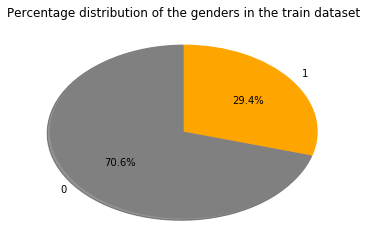

0    3260
1    1360
Name: gender, dtype: int64

In [10]:
type = df_train.gender.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Percentage distribution of the genders in the train dataset")
plt.show()

df_train.gender.value_counts()

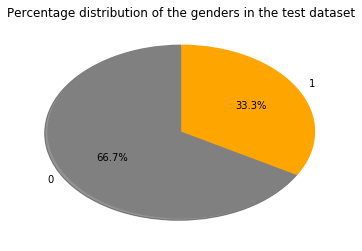

0    1120
1     560
Name: gender, dtype: int64

In [11]:
type = df_test.gender.value_counts()
labels = (np.array(type.index))
sizes = (np.array((type / type.sum())*100))
colors = ['grey', 'orange']
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Percentage distribution of the genders in the test dataset")
plt.show()

df_test.gender.value_counts()

Here, we clearly see that the data are not balanced - this could be detrimental to learning our models. We will therefore randomly delete data to rebalance them.

# Undersampling

We keep the 50/50 ratio of male and female speakers in each set.

In [12]:
df_train = utils.undersample(df_train, 'gender', 1)
print("Train")
print(df_train.gender.value_counts())
print("\n")

print("Test")
df_test = utils.undersample(df_test, 'gender', 1)
print(df_test.gender.value_counts())

Train
1    1360
0    1360
Name: gender, dtype: int64


Test
1    560
0    560
Name: gender, dtype: int64


# Extracting audio files

We recover all the paths of the audio files in order to extract the MFCCs of each audio file to create our training and testing data.MFCCs are computed using the librosa library. 

In [13]:
train_audio_list = df_train.soundPath.tolist()
test_audio_list = df_test.soundPath.tolist()

In [14]:
train_temp_features = []
test_temp_features = []

for elt in train_audio_list:
    train_temp_features.append(utils.extract_features(elt))

for elt in test_audio_list:
    test_temp_features.append(utils.extract_features(elt))

# Preparation of train and test data

In [15]:
X_train = np.array(train_temp_features)
y_train = np.array(df_train.gender.tolist())
X_test = np.array(test_temp_features)
y_test = np.array(df_test.gender.tolist())

# Machine Learning

We will here experiment with different classifiers and assess their performances.

### Gaussian Naive Bayes Classifier

The Gaussian Naive Bayes classifier makes the assumption that the features are independant and that each feature is normally distributed. It is a simple and fast classifier.

In [16]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Comparing the predicted values and the actual values, we have several possibilities:
* True positives (VP or TP): we predict "yes" and the expected value is "yes"
* True negatives (VN or TN): one predicts "no" and the expected value is "no"
* False positives (FP): we predict "yes" and the expected value is "no"
* False negatives (FN): one predicts "no" and the expected value is "yes"

The confusion matrix makes it possible to count the number of TP, TN, FP, FN. 


Then, we measure the accuracy of the model - number of times the algorithm has made a good prediction (in percentage). Nevertheless, this measure may be distorted in some cases, so we will use other estimators:

* the accuracy is the number of correct positive predictions on the total number of positive predictions: precision = VP / (VP + FP)
* the recall is the number of positive predictions about the actual number of "yes": recall = VP (VP + FN)
* the F1 score is the weighted average of accuracy and sensitivity: f1-score = 2xprecisionxrecall / (precision + recall)
 


Test accuracy :  0.9678571428571429 

7 males classified as females out of 560, 1.250 %
29 females classified as males out of 560, 5.179 %

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       560
           1       0.99      0.95      0.97       560

   micro avg       0.97      0.97      0.97      1120
   macro avg       0.97      0.97      0.97      1120
weighted avg       0.97      0.97      0.97      1120



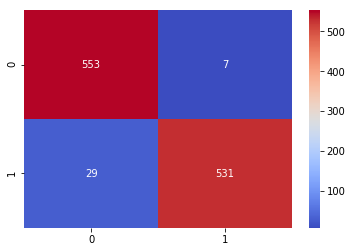

In [17]:
utils.test_gender_classifier(clf, X_test, y_test)

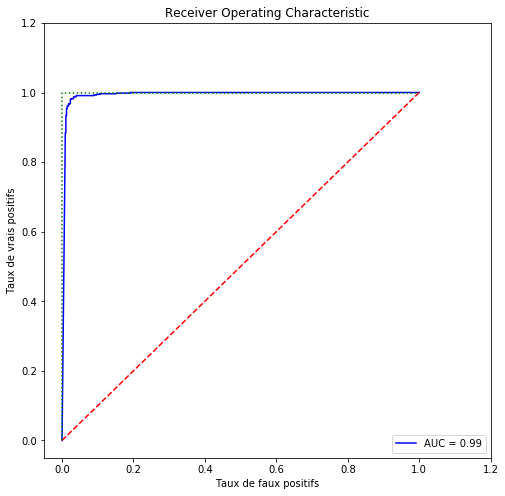

In [18]:
utils.plot_roc_curve(clf, X_test, y_test)

d:\program files\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


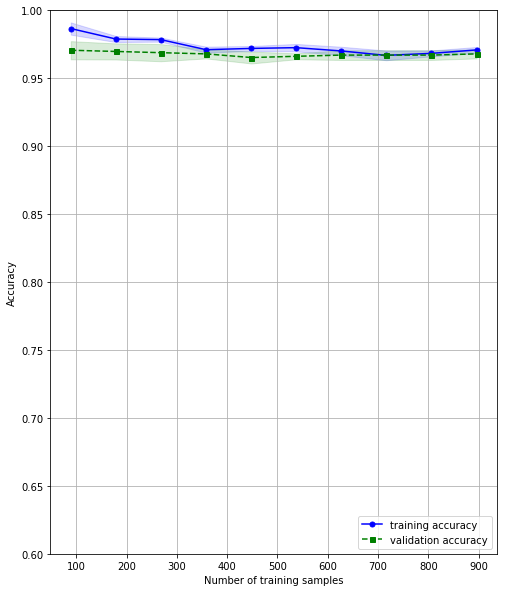

In [19]:
utils.plot_learning_curve(clf, X_test, y_test)

### XGBoost Classifier

XGBoost is one of the most popular machine learning algorithm these days : it is well known to provide better solutions than other machine learning algorithms. 

Test accuracy :  0.9758928571428571 

3 males classified as females out of 560, 0.536 %
24 females classified as males out of 560, 4.286 %

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       560
           1       0.99      0.96      0.98       560

   micro avg       0.98      0.98      0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120



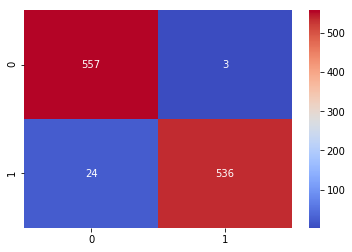

In [20]:
from xgboost import XGBClassifier 

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
utils.test_gender_classifier(xgb, X_test, y_test)

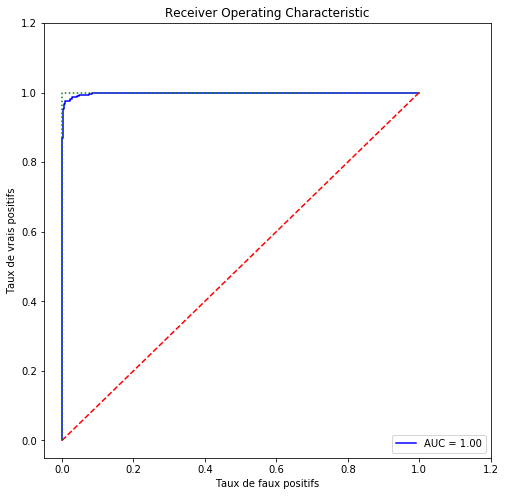

In [21]:
utils.plot_roc_curve(xgb, X_test, y_test)

d:\program files\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


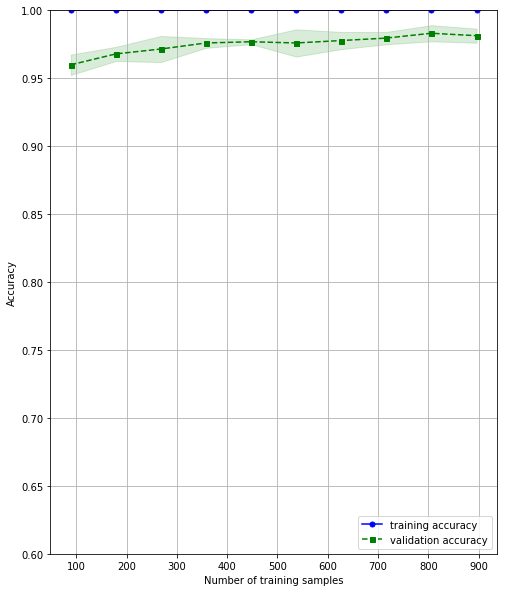

In [22]:
utils.plot_learning_curve(xgb, X_test, y_test)

### GradientBoosting Classifier

Test accuracy :  0.9767857142857143 

4 males classified as females out of 560, 0.714 %
22 females classified as males out of 560, 3.929 %

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       560
           1       0.99      0.96      0.98       560

   micro avg       0.98      0.98      0.98      1120
   macro avg       0.98      0.98      0.98      1120
weighted avg       0.98      0.98      0.98      1120



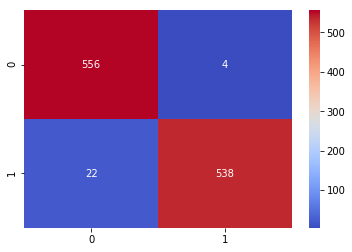

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
utils.test_gender_classifier(gb, X_test, y_test)

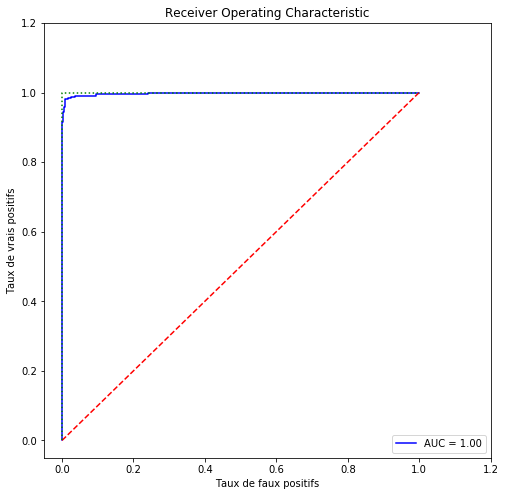

In [24]:
utils.plot_roc_curve(gb, X_test, y_test)

d:\program files\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


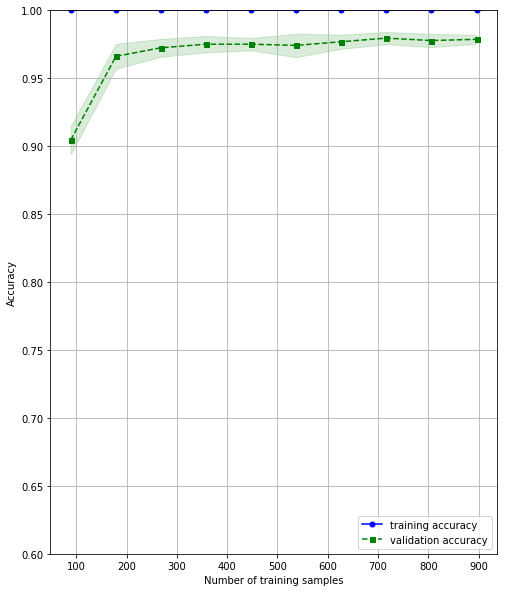

In [25]:
utils.plot_learning_curve(gb, X_test, y_test)

# Deep Learning

Here we will experiment with a simple neural network written in Keras. Our CNN is composed of fully connected layers and a sigmoid for binary classification. 

On average, the test accuracy is 95-97%

In [26]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               10496     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 51,713
Trainable params: 51,713
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
classifier = model.fit(X_train, y_train, batch_size=32, epochs=9, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 2720 samples, validate on 1120 samples
Epoch 1/9
2720/2720 [==============================] - 0s 162us/step - loss: 3.2102 - acc: 0.7154 - val_loss: 0.0848 - val_acc: 0.9688
Epoch 2/9
2720/2720 [==============================] - 0s 64us/step - loss: 0.0963 - acc: 0.9710 - val_loss: 0.0630 - val_acc: 0.9786
Epoch 3/9
2720/2720 [==============================] - 0s 60us/step - loss: 0.0707 - acc: 0.9779 - val_loss: 0.0990 - val_acc: 0.9661
Epoch 4/9
2720/2720 [==============================] - 0s 61us/step - loss: 0.0556 - acc: 0.9835 - val_loss: 0.0914 - val_acc: 0.9723
Epoch 5/9
2720/2720 [==============================] - 0s 62us/step - loss: 0.0684 - acc: 0.9772 - val_loss: 0.1282 - val_acc: 0.9679
Epoch 6/9
2720/2720 [==============================] - 0s 65us/step - loss: 0.0514 - acc: 0.9846 - val_loss: 0.0614 - val_acc: 0.9768
Epoch 7/9
2720/2720 [==============================] - 0s 57us/step - loss: 0.0421 - acc: 0.9846 - 

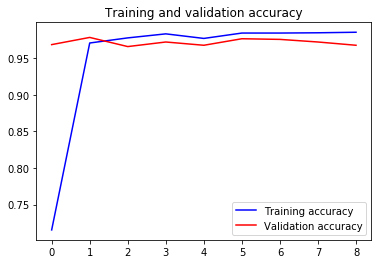

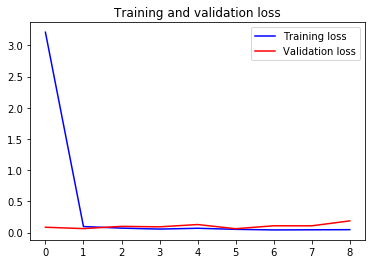

In [29]:
utils.model_curves(classifier)

In [30]:
classifier = model.save('gender_classifier.h5')

In [31]:
scores = model.evaluate(X_test, y_test)
print("Score : %.2f%%" % (scores[1]*100))

1120/1120 [==============================] - 0s 29us/step
Score : 96.79%


## Prediction

In [32]:
y_pred = model.predict(X_test)

In [33]:
from scipy.io import wavfile as wav
import IPython.display as ipd
import random

labels = ["male","female"]
n_test = X_test.shape[0]
ir = random.randint(0,n_test)

print("filename :", test_audio_list[ir])
print("model prediction :", labels[int(round(y_pred[ir][0]))])
ipd.Audio(test_audio_list[ir])

filename : TIMIT/TEST/DR4/FMAF0/SX199.wav
model prediction : female
